In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import os


In [2]:
# Load the data from the NPZ file from shooting method to validate model
loaded_data = np.load('../shooting_method/data_all.npz')

# Access the arrays using the keys ('r', 'A0', 'alpha0', 'phi0')
r = loaded_data['r']
A_shooting = loaded_data['A0']
alpha_shooting = loaded_data['alpha0']
phi_shooting = loaded_data['phi0']

function to define the nn architecture

In [3]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [4]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [5]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

define the model architecture

In [6]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
# (#input, #output,#neurons in each hidden layer, #of hidden layers)
model1 = FCN(1,4,64,4)#.to(device)
model2 = FCN(1,4,64,4)#.to(device)
model3 = FCN(1,4,64,4)#.to(device)
model4 = FCN(1,4,64,4)#.to(device)
model5 = FCN(1,4,64,4)#.to(device)


#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = 0.895042*torch.ones(1)#.to(device) 
phi0  = 0.05 * torch.ones(1)
#torch.nn.Parameter(0.895042*torch.ones(1))

load the models (same architecture, exported at different epochs)

In [ ]:
device = torch.device("cpu")

dir = "../models/GPU_non_compact_r_fixed_omega/"
dir = dir + "hard_Dirichlet_BC_r0_rmax_trig_neurons64_h_layers4_rmax1000_n2000_sigma0.1/"
#dir = dir + "model_epoch200000_last_layer_retrain_initial_lr1e-05_gamma0.9999948706837163/"

# make out dir to save plots
out_dir = dir+"/plots/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model1.load_state_dict(torch.load(dir + "model_epoch20000.pth", map_location=device))
model2.load_state_dict(torch.load(dir + "model_epoch40000.pth", map_location=device))
model3.load_state_dict(torch.load(dir + "model_epoch60000.pth", map_location=device))
model4.load_state_dict(torch.load(dir + "model_epoch80000.pth", map_location=device))
model5.load_state_dict(torch.load(dir + "model_epoch100000.pth", map_location=device))

# load total loss list
loss_list = np.load(dir + "total_loss.npz")["loss"]
# load individual losses
losses = np.load(dir + "losses.npz")["loss"]
# load learning rate list
lr_list = np.load(dir + "learning_rate.npz")["lr"]


/tmp/ipykernel_80219/2147742236.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(dir + "model_epoch20000.pth", map_location=device))
/t

Text(0.5, 0, 'epochs')

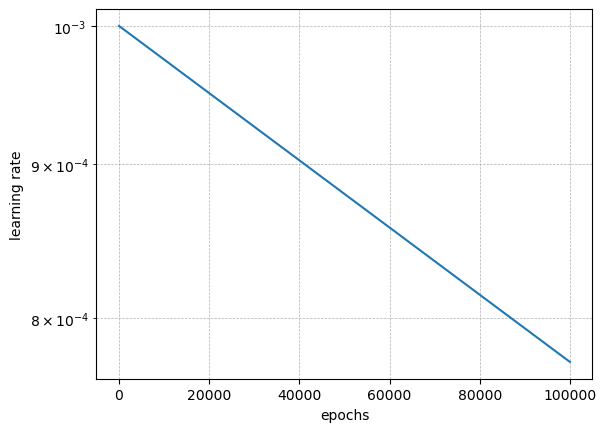

In [8]:
i = 1

ei = 0
ef = -1

# Plot in the second subplot
plt.semilogy(lr_list[ei:ef])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylabel("learning rate")
plt.xlabel("epochs")
#plt.ylabel(f"log(losses[{i}])")

#plt.savefig(f"./models/r_dom_fixed_omega_v3/loss_{i}.png", dpi=300, bbox_inches='tight')  # Save with high resolution


check values at r=0

In [9]:
rmax = 1000
R0 = torch.zeros(1, requires_grad=True)#.to(device)
pi = torch.pi

nn_sol_r01 = model1(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r02 = model2(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r03 = model3(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r04 = model4(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r05 = model5(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot


nn_A1, nn_alpha1, nn_chi_minus1, nn_phi1 = map(lambda i:  nn_sol_r01[[i]], range(4))
A1 = R0**0 + torch.sin(pi*R0/rmax)*nn_A1
alpha1 = R0**0 - torch.sin(0.5*pi*(1.0 + R0/rmax))*nn_alpha1
chi1 = torch.sin(pi*(1.0 + R0/rmax))*nn_chi_minus1
phi1 = phi0*torch.sin(0.5*pi*(1.0 + R0/rmax)) + torch.sin(pi*R0/rmax)*nn_phi1
alphar1 = gradients(alpha1, R0)
#
nn_A2, nn_alpha2, nn_chi_minus2, nn_phi2 = map(lambda i:  nn_sol_r02[[i]], range(4))
A2 = R0**0 + torch.sin(pi*R0/rmax)*nn_A2
alpha2 = R0**0 - torch.sin(0.5*pi*(1.0 + R0/rmax))*nn_alpha2
chi2 = torch.sin(pi*(1.0 + R0/rmax))*nn_chi_minus2
phi2 = phi0*torch.sin(0.5*pi*(1.0 + R0/rmax)) + torch.sin(pi*R0/rmax)*nn_phi2
alphar2 = gradients(alpha2, R0)
#
nn_A3, nn_alpha3, nn_chi_minus3, nn_phi3 = map(lambda i:  nn_sol_r03[[i]], range(4))
A3 = R0**0 + torch.sin(pi*R0/rmax)*nn_A3
alpha3 = R0**0 - torch.sin(0.5*pi*(1.0 + R0/rmax))*nn_alpha3
chi3 = torch.sin(pi*(1.0 + R0/rmax))*nn_chi_minus3
phi3 = phi0*torch.sin(0.5*pi*(1.0 + R0/rmax)) + torch.sin(pi*R0/rmax)*nn_phi3
alphar3 = gradients(alpha3, R0)
#
nn_A4, nn_alpha4, nn_chi_minus4, nn_phi4 = map(lambda i:  nn_sol_r04[[i]], range(4))
A4 = R0**0 + torch.sin(pi*R0/rmax)*nn_A4
alpha4 = R0**0 - torch.sin(0.5*pi*(1.0 + R0/rmax))*nn_alpha4
chi4 = torch.sin(pi*(1.0 + R0/rmax))*nn_chi_minus4
phi4 = phi0*torch.sin(0.5*pi*(1.0 + R0/rmax)) + torch.sin(pi*R0/rmax)*nn_phi4
alphar4 = gradients(alpha4, R0)
#
nn_A5, nn_alpha5, nn_chi_minus5, nn_phi5 = map(lambda i:  nn_sol_r05[[i]], range(4))
A5 = R0**0 + torch.sin(pi*R0/rmax)*nn_A5
alpha5 = R0**0 - torch.sin(0.5*pi*(1.0 + R0/rmax))*nn_alpha5
chi5 = torch.sin(pi*(1.0 + R0/rmax))*nn_chi_minus5
phi5 = phi0*torch.sin(0.5*pi*(1.0 + R0/rmax)) + torch.sin(pi*R0/rmax)*nn_phi5
alphar5 = gradients(alpha5, R0)


print("A_nn_r01 =",A1.item())
print("A_nn_r02 =",A2.item())
print("A_nn_r03 =",A3.item())
print("A_nn_r04 =",A4.item())
print("A_nn_r05 =",A5.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r01 =",alpha1.item())
print("alpha_nn_r02 =",alpha2.item())
print("alpha_nn_r03 =",alpha3.item())
print("alpha_nn_r04 =",alpha4.item())
print("alpha_nn_r05 =",alpha5.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r01 =",chi1.item())
print("chi_nn_r02 =",chi2.item())
print("chi_nn_r03 =",chi3.item())
print("chi_nn_r04 =",chi4.item())
print("chi_nn_r05 =",chi5.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r01 =",phi1.item())
print("phi_nn_r02 =",phi2.item())
print("phi_nn_r03 =",phi3.item())
print("phi_nn_r04 =",phi4.item())
print("phi_nn_r05 =",phi5.item())
print("phi0_r0   =",phi0.item())
print("")

print("alphar_nn_r01 =",alphar1.item())
print("alphar_nn_r02 =",alphar2.item())
print("alphar_nn_r03 =",alphar3.item())
print("alphar_nn_r04 =",alphar4.item())
print("alphar_nn_r05 =",alphar5.item())
print("alphar_r0    =",0)

A_nn_r01 = 1.0
A_nn_r02 = 1.0
A_nn_r03 = 1.0
A_nn_r04 = 1.0
A_nn_r05 = 1.0
A_r0    = 1

alpha_nn_r01 = 0.9929021596908569
alpha_nn_r02 = 0.9999995827674866
alpha_nn_r03 = 1.0
alpha_nn_r04 = 1.0
alpha_nn_r05 = 1.0
alpha_r0    > 0

chi_nn_r01 = -1.0838457215056607e-10
chi_nn_r02 = -7.263115347870552e-13
chi_nn_r03 = -4.9845275849273295e-15
chi_nn_r04 = -6.10249519060791e-17
chi_nn_r05 = -5.284312317885989e-17
chi_r0    = 0

phi_nn_r01 = 0.05000000074505806
phi_nn_r02 = 0.05000000074505806
phi_nn_r03 = 0.05000000074505806
phi_nn_r04 = 0.05000000074505806
phi_nn_r05 = 0.05000000074505806
phi0_r0   = 0.05000000074505806

alphar_nn_r01 = 0.00010501221549930051
alphar_nn_r02 = 5.112570367060698e-09
alphar_nn_r03 = 1.6761375273843804e-13
alphar_nn_r04 = 6.341055733629428e-18
alphar_nn_r05 = 2.779059963183654e-20
alphar_r0    = 0


/home/thanasis/anaconda3/envs/pinns/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


check values at training rmax

In [10]:
RMAX = 1000
rmax = RMAX*torch.ones(1, requires_grad=True)#.to(device)
nn_sol_rmax = model5(rmax)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_A, nn_alpha, nn_chi_minus, nn_phi = map(lambda i:  nn_sol_rmax[[i]], range(4))

A = rmax**0 + torch.sin(pi*rmax/RMAX)*nn_A
alpha = rmax**0 - torch.sin(0.5*pi*(1.0 + rmax/RMAX))*nn_alpha
chi = torch.sin(pi*(1.0 + rmax/RMAX))*nn_chi_minus
phi = phi0*torch.sin(0.5*pi*(1.0 + rmax/RMAX)) + torch.sin(pi*rmax/RMAX)*nn_phi
alphar = gradients(alpha, rmax)

print("A_nn_rmax =",A.item())
print("A_rmax    =",1)
print("")

print("alpha_nn_rmax =",alpha.item())
print("alpha_rmax    =",1)
print("")

print("chi_nn_rmax =",chi.item())
print("chi_rmax    =",0)
print("")

print("phi_nn_rmax =",phi.item())
print("phi0_rmax   =",0)

A_nn_rmax = 1.0
A_rmax    = 1

alpha_nn_rmax = 1.0
alpha_rmax    = 1

chi_nn_rmax = 1.0497305123357656e-16
chi_rmax    = 0

phi_nn_rmax = -4.371139006309477e-09
phi0_rmax   = 0


get the solution of the nn for the exact r domain used by shooting

In [11]:
# the time domain; used to visualize the analytical solution
N = len(r) #1000
RMAX = r[-1]
R = torch.linspace(0,RMAX,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
rr = torch.linspace(0,RMAX,N).view(-1,1)#.to(device)

nn_sol1 = model1(rr)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol2 = model2(rr)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol3 = model3(rr)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol4 = model4(rr)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol5 = model5(rr)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot

RR = rr.cpu().detach().numpy()

nn_A1, nn_alpha1, nn_chi_minus1, nn_phi1 = map(lambda i:  nn_sol1[:,[i]], range(4))
A1 = rr**0 + torch.sin(pi*rr/rmax)*nn_A1 # either sin in np or detach tensors later
alpha1 = rr**0 - torch.sin(0.5*pi*(1.0 + rr/rmax))*nn_alpha1
chi1 = torch.sin(pi*(1.0 + rr/rmax))*nn_chi_minus1
phi1 = phi0*torch.sin(0.5*pi*(1.0 + rr/rmax)) + torch.sin(pi*rr/rmax)*nn_phi1
#alphar1 = gradients(alpha1, rr)
#
nn_A2, nn_alpha2, nn_chi_minus2, nn_phi2 = map(lambda i:  nn_sol2[:,[i]], range(4))
A2 = rr**0 + torch.sin(pi*rr/rmax)*nn_A2
alpha2 = rr**0 - torch.sin(0.5*pi*(1.0 + rr/rmax))*nn_alpha2
chi2 = torch.sin(pi*(1.0 + rr/rmax))*nn_chi_minus2
phi2 = phi0*torch.sin(0.5*pi*(1.0 + rr/rmax)) + torch.sin(pi*rr/rmax)*nn_phi2
#alphar2 = gradients(alpha2, rr)
#
nn_A3, nn_alpha3, nn_chi_minus3, nn_phi3 = map(lambda i:  nn_sol3[:,[i]], range(4))
A3 = rr**0 + torch.sin(pi*rr/rmax)*nn_A3
alpha3 = rr**0 - torch.sin(0.5*pi*(1.0 + rr/rmax))*nn_alpha3
chi3 = torch.sin(pi*(1.0 + rr/rmax))*nn_chi_minus3
phi3 = phi0*torch.sin(0.5*pi*(1.0 + rr/rmax)) + torch.sin(pi*rr/rmax)*nn_phi3
#alphar3 = gradients(alpha3, rr)
#
nn_A4, nn_alpha4, nn_chi_minus4, nn_phi4 = map(lambda i:  nn_sol4[:,[i]], range(4))
A4 = rr**0 + torch.sin(pi*rr/rmax)*nn_A4
alpha4 = rr**0 - torch.sin(0.5*pi*(1.0 + rr/rmax))*nn_alpha4
chi4 = torch.sin(pi*(1.0 + rr/rmax))*nn_chi_minus4
phi4 = phi0*torch.sin(0.5*pi*(1.0 + rr/rmax)) + torch.sin(pi*rr/rmax)*nn_phi4
#alphar4 = gradients(alpha4, rr)
#
nn_A5, nn_alpha5, nn_chi_minus5, nn_phi5 = map(lambda i:  nn_sol5[:,[i]], range(4))
A5 = rr**0 + torch.sin(pi*rr/rmax)*nn_A5
alpha5 = rr**0 - torch.sin(0.5*pi*(1.0 + rr/rmax))*nn_alpha5
chi5 = torch.sin(pi*(1.0 + rr/rmax))*nn_chi_minus5
phi5 = phi0*torch.sin(0.5*pi*(1.0 + rr/rmax)) + torch.sin(pi*rr/rmax)*nn_phi5
#alphar5 = gradients(alpha5, rr)



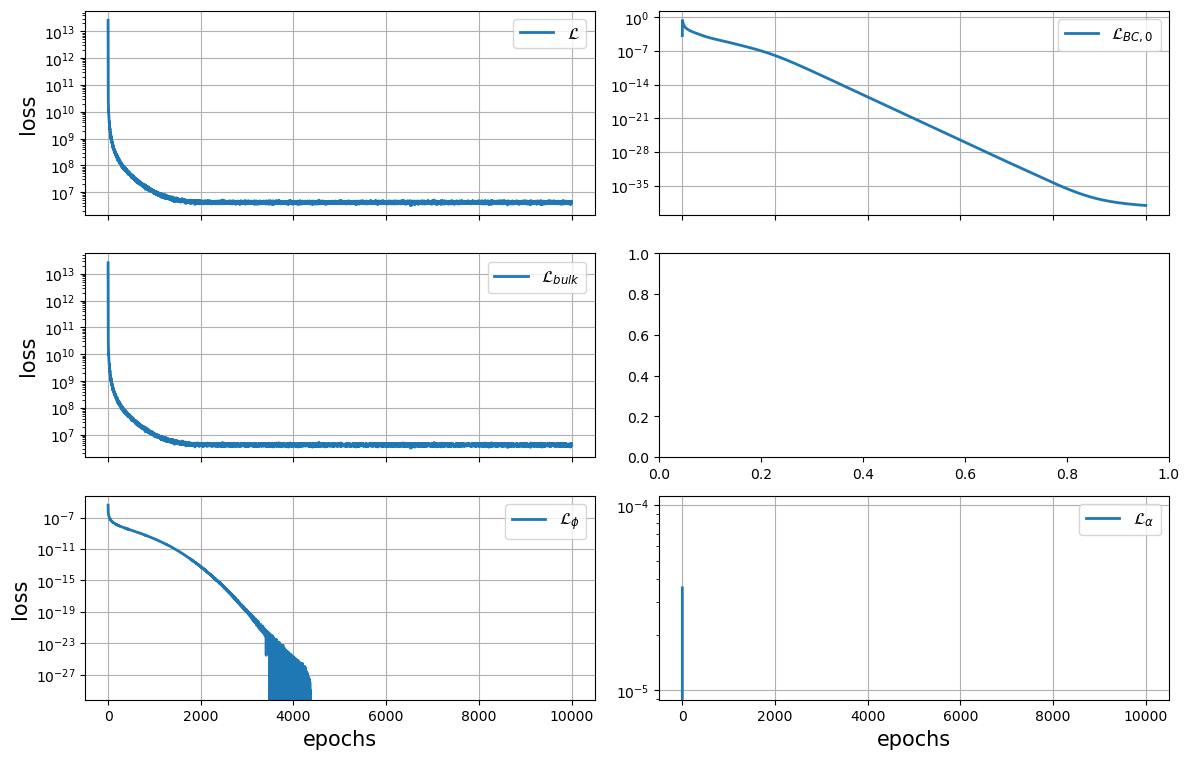

In [12]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12

step = 10

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# total loss

axs[0,0].plot(loss_list[0:-1:step], label=r"$\mathcal{L}$", lw=2, color="tab:blue",linestyle="-")
axs[0,0].set_yscale("log")
axs[0,0].grid(True)
axs[0,0].set_ylabel("loss", fontsize=l_size)
axs[0,0].legend(loc="upper right",fontsize=legend_fsize)
axs[0,0].set_xticklabels([])  # Remove x-axis tick labels

# loss at r0 (BC)

axs[0,1].plot(losses[0][0:-1:step], label=r"$\mathcal{L}_{BC,0}$", lw=2, color="tab:blue",linestyle="-")
axs[0,1].set_yscale("log")
axs[0,1].grid(True)
axs[0,1].set_xticklabels([])  # Remove x-axis tick labels
axs[0,1].legend(loc="upper right",fontsize=legend_fsize)
#axs[0,1].set_ylim(10**(-5),1)

# bulk loss

axs[1,0].plot(losses[1][0:-1:step], label=r"$\mathcal{L}_{bulk}$", lw=2, color="tab:blue",linestyle="-")
axs[1,0].set_yscale("log")
axs[1,0].grid(True)
axs[1,0].set_ylabel("loss", fontsize=l_size)
axs[1,0].set_xticklabels([])  # Remove x-axis tick label
axs[1,0].legend(loc="upper right",fontsize=legend_fsize)

# # loss at rmax BC

# axs[1,1].plot(losses[2][0:-1:step], label=r"$\mathcal{L}_{BC,r_{max}}$", lw=2, color="tab:blue",linestyle="-")
# axs[1,1].set_yscale("log")
# axs[1,1].grid(True)
# axs[1,1].set_xticklabels([])  # Remove x-axis tick labels
# axs[1,1].legend(loc="upper right",fontsize=legend_fsize)

# loss for phi monotonicity

axs[2,0].plot(losses[2][0:-1:step], label=r"$\mathcal{L}_{\phi}$", lw=2, color="tab:blue",linestyle="-")
axs[2,0].set_yscale("log")
axs[2,0].grid(True)
axs[2,0].set_ylabel("loss", fontsize=l_size)
axs[2,0].set_xlabel("epochs", fontsize=l_size)
axs[2,0].legend(loc="upper right",fontsize=legend_fsize)

# loss for alpha monotonicity

axs[2,1].plot(losses[3][0:-1:step], label=r"$\mathcal{L}_{\alpha}$", lw=2, color="tab:blue",linestyle="-")
axs[2,1].set_yscale("log")
axs[2,1].grid(True)
axs[2,1].set_xlabel("epochs", fontsize=l_size)
axs[2,1].legend(loc="upper right",fontsize=legend_fsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"losses.pdf")


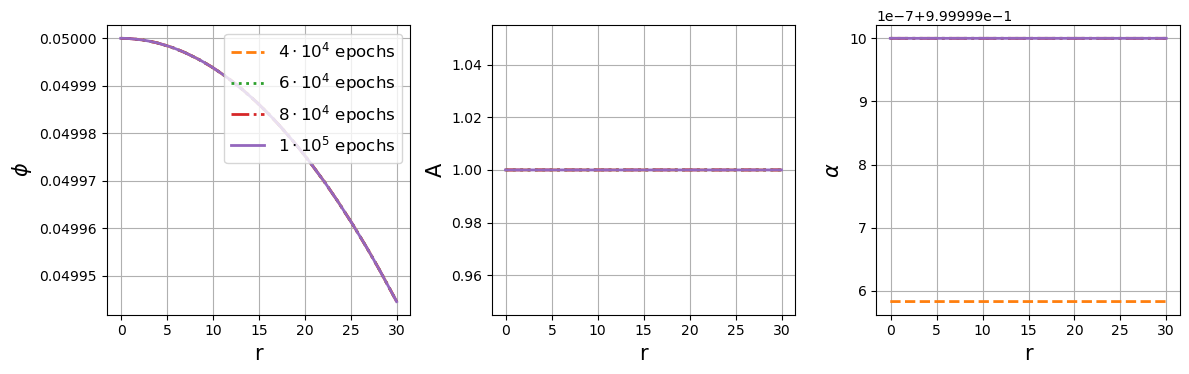

In [13]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12


# Create subplots
fig, axs = plt.subplots(1,3, figsize=(12, 4))

# phi sols

#axs[0].plot(r, phi1, label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:blue",linestyle="-")
axs[0].plot(r, phi2.cpu().detach().numpy().flatten(), label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:orange",linestyle="--")
axs[0].plot(r, phi3.cpu().detach().numpy().flatten(), label=r"$6 \cdot 10^4$"+" epochs", lw=2, color="tab:green",linestyle=":")
axs[0].plot(r, phi4.cpu().detach().numpy().flatten(), label=r"$8 \cdot 10^4$"+" epochs", lw=2, color="tab:red",linestyle="-.")
axs[0].plot(r, phi5.cpu().detach().numpy().flatten(), label=r"$1 \cdot 10^5$"+" epochs", lw=2, color="tab:purple",linestyle="-")
#axs[0].plot(r, phi_shooting, label="shooting", lw=1.5, color="black",linestyle="--")
axs[0].grid(True)
axs[0].set_ylabel(r"$\phi$", fontsize=l_size)
axs[0].legend(loc="upper right",fontsize=legend_fsize)
#axs[0].set_xticklabels([])  # Remove x-axis tick label
axs[0].set_xlabel("r", fontsize=l_size)

# A sols
#axs[1].plot(r, A1, lw=2, color="tab:blue",linestyle="-")
axs[1].plot(r, A2.cpu().detach().numpy().flatten(), lw=2, color="tab:orange",linestyle="--")
axs[1].plot(r, A3.cpu().detach().numpy().flatten(), lw=2, color="tab:green",linestyle=":")
axs[1].plot(r, A4.cpu().detach().numpy().flatten(), lw=2, color="tab:red",linestyle="-.")
axs[1].plot(r, A5.cpu().detach().numpy().flatten(), lw=2, color="tab:purple",linestyle="-")
#axs[1].plot(r, A_shooting, lw=1.5, color="black",linestyle="--")
axs[1].grid(True)
axs[1].set_ylabel("A", fontsize=l_size)
#axs[1].set_xticklabels([])  # Remove x-axis tick label
axs[1].set_xlabel("r", fontsize=l_size)

# alpha sol
#axs[2].plot(r, alpha1, lw=2, color="tab:blue",linestyle="-")
axs[2].plot(r, alpha2.cpu().detach().numpy().flatten(), lw=2, color="tab:orange",linestyle="--")
axs[2].plot(r, alpha3.cpu().detach().numpy().flatten(), lw=2, color="tab:green",linestyle=":")
axs[2].plot(r, alpha4.cpu().detach().numpy().flatten(), lw=2, color="tab:red",linestyle="-.")
axs[2].plot(r, alpha5.cpu().detach().numpy().flatten(), lw=2, color="tab:purple",linestyle="-")
#axs[2].plot(r, alpha_shooting, lw=1.5, color="black",linestyle="--")
axs[2].grid(True)
axs[2].set_ylabel(r"$\alpha$", fontsize=l_size)
axs[2].set_xlabel("r", fontsize=l_size)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"solutions.pdf")


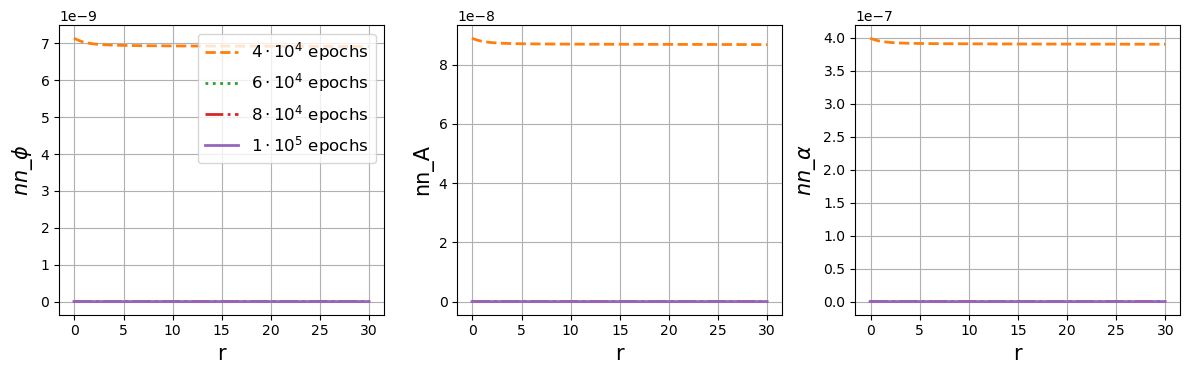

In [27]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12


# Create subplots
fig, axs = plt.subplots(1,3, figsize=(12, 4))

# phi sols

#axs[0].plot(r, phi1, label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:blue",linestyle="-")
axs[0].plot(r, nn_phi2.cpu().detach().numpy().flatten(), label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:orange",linestyle="--")
axs[0].plot(r, nn_phi3.cpu().detach().numpy().flatten(), label=r"$6 \cdot 10^4$"+" epochs", lw=2, color="tab:green",linestyle=":")
axs[0].plot(r, nn_phi4.cpu().detach().numpy().flatten(), label=r"$8 \cdot 10^4$"+" epochs", lw=2, color="tab:red",linestyle="-.")
axs[0].plot(r, nn_phi5.cpu().detach().numpy().flatten(), label=r"$1 \cdot 10^5$"+" epochs", lw=2, color="tab:purple",linestyle="-")
#axs[0].plot(r, phi_shooting, label="shooting", lw=1.5, color="black",linestyle="--")
axs[0].grid(True)
axs[0].set_ylabel(r"$nn\_\phi$", fontsize=l_size)
axs[0].legend(loc="upper right",fontsize=legend_fsize)
#axs[0].set_xticklabels([])  # Remove x-axis tick label
axs[0].set_xlabel("r", fontsize=l_size)

# A sols
#axs[1].plot(r, A1, lw=2, color="tab:blue",linestyle="-")
axs[1].plot(r, nn_A2.cpu().detach().numpy().flatten(), lw=2, color="tab:orange",linestyle="--")
axs[1].plot(r, nn_A3.cpu().detach().numpy().flatten(), lw=2, color="tab:green",linestyle=":")
axs[1].plot(r, nn_A4.cpu().detach().numpy().flatten(), lw=2, color="tab:red",linestyle="-.")
axs[1].plot(r, nn_A5.cpu().detach().numpy().flatten(), lw=2, color="tab:purple",linestyle="-")
#axs[1].plot(r, A_shooting, lw=1.5, color="black",linestyle="--")
axs[1].grid(True)
axs[1].set_ylabel("nn_A", fontsize=l_size)
#axs[1].set_xticklabels([])  # Remove x-axis tick label
axs[1].set_xlabel("r", fontsize=l_size)

# alpha sol
#axs[2].plot(r, alpha1, lw=2, color="tab:blue",linestyle="-")
axs[2].plot(r, nn_alpha2.cpu().detach().numpy().flatten(), lw=2, color="tab:orange",linestyle="--")
axs[2].plot(r, nn_alpha3.cpu().detach().numpy().flatten(), lw=2, color="tab:green",linestyle=":")
axs[2].plot(r, nn_alpha4.cpu().detach().numpy().flatten(), lw=2, color="tab:red",linestyle="-.")
axs[2].plot(r, nn_alpha5.cpu().detach().numpy().flatten(), lw=2, color="tab:purple",linestyle="-")
#axs[2].plot(r, alpha_shooting, lw=1.5, color="black",linestyle="--")
axs[2].grid(True)
axs[2].set_ylabel(r"$nn\_\alpha$", fontsize=l_size)
axs[2].set_xlabel("r", fontsize=l_size)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"nn_solutions.pdf")
